In [ ]:
import requests
from bs4 import BeautifulSoup
from multiprocessing.dummy import Pool as ThreadPool
import time
from itertools import chain
import re
import json
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Парсинг данных

In [ ]:
pool = ThreadPool(80)
urls = [f"https://www.banki.ru/services/responses/bank/alfabank/?page={i}" for i in range(1, 81)]
start_time1 = time.time()
results = pool.map(requests.get, urls)
start_time2 = time.time()
print(f"Время отправки и получения запросов: {start_time2-start_time1} секунд.")
bs_results = pool.map(BeautifulSoup, [res.text for res in results])
start_time3 = time.time()
print(f"Время обработки полученных запросов: {start_time3-start_time2} секунд.")
pool.close()
pool.join()
len(bs_results)

Время отправки и получения запросов: 27.220414400100708 секунд.


/usr/lib/python3.10/multiprocessing/pool.py:48: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 48 of the file /usr/lib/python3.10/multiprocessing/pool.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  return list(map(*args))


Время обработки полученных запросов: 16.302439212799072 секунд.


80

In [ ]:
bs_links = list(filter(lambda x: x,
                      (map(lambda x: "https://www.banki.ru" + x.find("a", {"class": "link-simple"})['href']
                      if x.find("a", {"class": "link-simple"}) else None,
                      chain.from_iterable([bs.find_all("div", {"class": "la8a5ef73"}) for bs in bs_results])))))
len(bs_links), bs_links[0]

(2000, 'https://www.banki.ru/services/responses/bank/response/11115860/')

In [ ]:
start_time = time.time()
pool = ThreadPool(80)
bs_reviews = []
for i in range(25):
  bs_reviews = list(chain(bs_reviews, pool.map(requests.get, [link for link in bs_links[i*80:80*(i+1)]])))
  print(f"{i+1}/25")
pool.close()
end_time = time.time()
print(f"Время получения ссылок: {end_time-start_time} секунд.")
len(bs_reviews)

1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25
Время получения ссылок: 407.1162357330322 секунд.


2000

In [ ]:
#Получаем данные отзыва в формате json
data = json.loads('[' + re.sub(r'[\n\r/\xa0\\\t]', '', ','.join(["".join(BeautifulSoup(review.text).find("main", {"class": "page-container__body"}).find("script", {"type": "application/ld+json"}, 'html.parser').contents) for review in bs_reviews]).replace("&lt;", "").replace('p&gt;', "").replace("/p&gt;", "")) + ']')
data[0]

{'@context': 'https:schema.org',
 '@type': 'Review',
 'itemReviewed': {'@type': 'Organization', 'name': 'Альфа-Банк'},
 'reviewRating': {'@type': 'Rating',
  'bestRating': '5',
  'ratingValue': '1',
  'worstRating': '1'},
 'name': 'Реферальная программа приведи друга и невыполнение условий по ней',
 'author': {'@type': 'Person',
  'name': 'user-690015321985',
  'reviewBody': 'Добрый день.Хочу поделиться отзывом о реферальной программе банка. В целом она прекрасна, за дебетовую карту вы получаете 1500, друг 500, за кредитную 2500, друг так же 500.Но есть одно НО! По какой-то причине банк решил не выплачивать вознаграждение ни мне ни другу, хотя все условия были выполнены в полном объеме. Когда я обратился в службу поддержки, то мне посочувствовали, пообещали принять меры в будущем. Это все прекрасно, а общанные выплаты где? Кажется должно быть все честно, разве нет? После повторного обращения по этому же вопросу от 7 сентября, ответа я так и не получил... Продолжаю ждать и надеяться на 

In [ ]:
len(data)

2000

# Удаление лишних данных

In [ ]:
df = pd.json_normalize(data)
df.head()

,@context,@type,name,itemReviewed.@type,itemReviewed.name,reviewRating.@type,reviewRating.bestRating,reviewRating.ratingValue,reviewRating.worstRating,author.@type,author.name,author.reviewBody
0,https:schema.org,Review,Реферальная программа приведи друга и невыполн...,Organization,Альфа-Банк,Rating,5,1,1,Person,user-690015321985,Добрый день.Хочу поделиться отзывом о рефераль...
1,https:schema.org,Review,Это было самое быстрое решение моего вопроса,Organization,Альфа-Банк,Rating,5,5,1,Person,user-18439682174,15 сентября обратилась в чат мобильного прилож...
2,https:schema.org,Review,Невыплата бонуса за рекомендацию,Organization,Альфа-Банк,Rating,5,2,1,Person,user2203223,"С банком знакома давно и пользуюсь услугами,вс..."
3,https:schema.org,Review,"Любая консультация онлайн, без звонка и посеще...",Organization,Альфа-Банк,Rating,5,4,1,Person,user-825111845185,"Очень удобно, что в наше время можно обратитьс..."
4,https:schema.org,Review,"Ужасное отношение, неправомерно забирают деньги!",Organization,Альфа-Банк,Rating,5,1,1,Person,user-15293283,14 сентября 2023 примерно в 14.30 снимал скруп...


In [ ]:
df.isnull().sum()

@context                    0
@type                       0
name                        0
itemReviewed.@type          0
itemReviewed.name           0
reviewRating.@type          0
reviewRating.bestRating     0
reviewRating.ratingValue    0
reviewRating.worstRating    0
author.@type                0
author.name                 0
author.reviewBody           0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   @context                  2000 non-null   object
 1   @type                     2000 non-null   object
 2   name                      2000 non-null   object
 3   itemReviewed.@type        2000 non-null   object
 4   itemReviewed.name         2000 non-null   object
 5   reviewRating.@type        2000 non-null   object
 6   reviewRating.bestRating   2000 non-null   object
 7   reviewRating.ratingValue  2000 non-null   object
 8   reviewRating.worstRating  2000 non-null   object
 9   author.@type              2000 non-null   object
 10  author.name               2000 non-null   object
 11  author.reviewBody         2000 non-null   object
dtypes: object(12)
memory usage: 187.6+ KB


Во избежание избыточности признаков, по количеству уникальных значений можно отсечь некоторые данные, так как нас не интересуют колонки с только одним уникальным значением

In [ ]:
df.nunique()

@context                       1
@type                          1
name                        1734
itemReviewed.@type             1
itemReviewed.name              1
reviewRating.@type             1
reviewRating.bestRating        1
reviewRating.ratingValue       5
reviewRating.worstRating       1
author.@type                   1
author.name                 1859
author.reviewBody           1999
dtype: int64

In [ ]:
df.drop(["@context", "@type", "itemReviewed.@type", "itemReviewed.name", "reviewRating.@type","reviewRating.bestRating", "reviewRating.worstRating", "author.@type"], axis=1, inplace=True)

Также нас не интересуют имена пользователей, оставивших отзыв, ибо они не могут повлиять на обучение модели

In [ ]:
df.drop("author.name", axis=1, inplace=True)
df.head()

,name,reviewRating.ratingValue,author.reviewBody
0,Реферальная программа приведи друга и невыполн...,1,Добрый день.Хочу поделиться отзывом о рефераль...
1,Это было самое быстрое решение моего вопроса,5,15 сентября обратилась в чат мобильного прилож...
2,Невыплата бонуса за рекомендацию,2,"С банком знакома давно и пользуюсь услугами,вс..."
3,"Любая консультация онлайн, без звонка и посеще...",4,"Очень удобно, что в наше время можно обратитьс..."
4,"Ужасное отношение, неправомерно забирают деньги!",1,14 сентября 2023 примерно в 14.30 снимал скруп...


Сменим названия колонок для удобства и читабельности

In [ ]:
df.rename(columns = {'name':'review_name', 'reviewRating.ratingValue':'review_rate', 'author.reviewBody':'review_body'}, inplace = True )
df.columns

Index(['review_name', 'review_rate', 'review_body'], dtype='object')

In [ ]:
df["review_rate"] = df["review_rate"].apply(int)

Процентаж отзывов по количеству рейтинга

<Axes: ylabel='review_rate'>

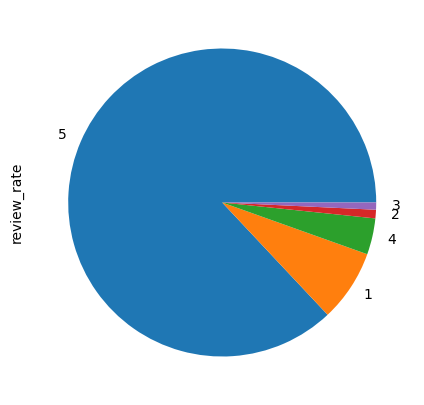

In [ ]:
df["review_rate"].value_counts().plot.pie(y="", figsize=(5,5))

Зависимость оценки от количества символов в шапке отзыва

<Axes: xlabel='rate'>

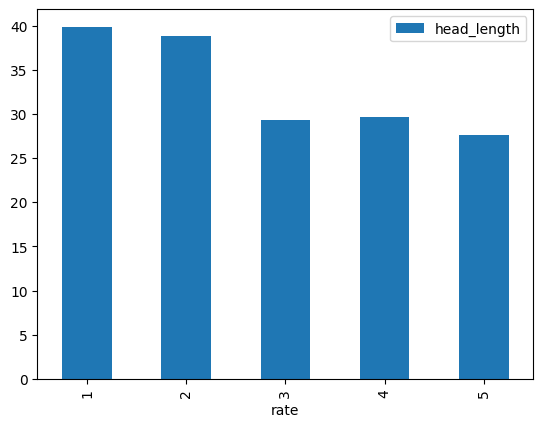

In [ ]:
df2 = pd.DataFrame()
df2["rate"] = df["review_rate"]
df2["head_length"] = df["review_name"].apply(len)
df2.groupby(["rate"]).mean().plot.bar()

Зависимость оценки от количества символов в теле отзыва

<Axes: xlabel='rate'>

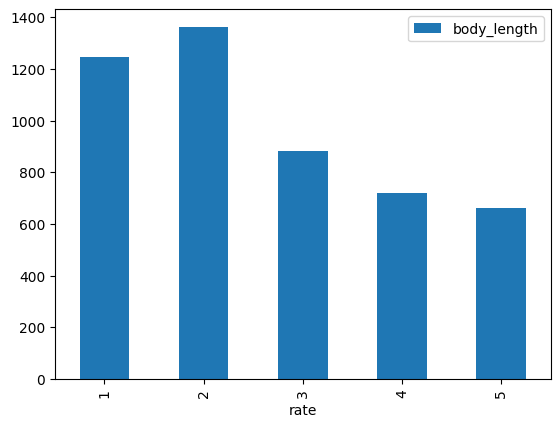

In [ ]:
df3 = pd.DataFrame()
df3["rate"] = df["review_rate"]
df3["body_length"] = df["review_body"].apply(len)
df3.groupby(["rate"]).mean().plot.bar()

# Очистка данных

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stem = SnowballStemmer('russian')
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('russian'))

In [ ]:
def cleanalyzer(text):
    text = (re.sub(r'\d+', '', text)).lower() # убираем цифры (даты), приводим к нижнему регистру
    text = word_tokenize(text) # разбиваем на слова
    text = [lemma.lemmatize(word) for word in text if word not in stop_words] # приводим слова, не относящиеся к стоп-словам, к лемме
    text = [word for word in text if len(word) > 3 and len(word) < 30] # убираем слова, не попадающие длиной в промежуток
    text = [stem.stem(word) for word in text] # отрезаем лишнее от корней оставшихся слов
    text = ' '.join(text) # приводим к строке
    return text

In [ ]:
df["review_name"] = df["review_name"].apply(cleanalyzer)
df["review_body"] = df["review_body"].apply(cleanalyzer)

In [ ]:
df.head()

,review_name,review_rate,review_body
0,реферальн программ привед друг невыполнен услов,1,добр день.хоч подел отзыв реферальн программ б...
1,сам быстр решен мо вопрос,5,сентябр обрат мобильн приложен даб узна имеющ ...
2,невыплат бонус рекомендац,2,банк знаком давн польз услуг кэшбэк бонус прих...
3,люб консультац онлайн звонк посещен офис банк,4,очен удобн наш врем обрат помощ онлайн нужн ид...
4,ужасн отношен неправомерн забира деньг,1,сентябр примерн снима скрупн сумм сторон банко...


# Векторизация

In [ ]:
vectorizer_name = TfidfVectorizer()
vectorizer_body = TfidfVectorizer()

In [ ]:
y = df['review_rate']
X_name = vectorizer_name.fit_transform(df['review_name'])
X_1 = pd.DataFrame(X_name.toarray(), columns=vectorizer_name.get_feature_names_out())
X_body = vectorizer_body.fit_transform(df['review_body'])
X_2 = pd.DataFrame(X_body.toarray(), columns=vectorizer_body.get_feature_names_out())

In [ ]:
y.shape, X_1.shape, X_2.shape

((2000,), (2000, 1041), (2000, 8594))

In [ ]:
X = pd.concat([X_1, X_2], axis=1)
X.shape

(2000, 9635)

# Различные виды классификации

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
Gaussian = GaussianNB()
KNeighbors = KNeighborsClassifier()
RandomForest = RandomForestClassifier(n_estimators=100)
LogRegression = LogisticRegression()
Ridge = RidgeClassifier()

In [ ]:
def execute_model(X, y, model):
	start = time.time()
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	train_time = time.time() - start
	return scores, train_time

In [ ]:
results = pd.DataFrame({"model": [], "mean accuracy":[], "train time": []})
all_scores = []
for i in [Gaussian, KNeighbors, RandomForest, LogRegression, Ridge]:
  print(f"начинается обучение модели {i}")
  scores, train_time = execute_model(X, y, i)
  results.loc[len(results.index)] = [i, np.mean(scores), train_time]
  all_scores.append(scores)
results

начинается обучение модели GaussianNB()
начинается обучение модели KNeighborsClassifier()
начинается обучение модели RandomForestClassifier()
начинается обучение модели LogisticRegression()
начинается обучение модели RidgeClassifier()


,model,mean accuracy,train time
0,GaussianNB(),0.870833,29.767088
1,KNeighborsClassifier(),0.875333,28.950815
2,RandomForestClassifier(),0.874000,108.437292
3,LogisticRegression(),0.888000,137.257087
4,RidgeClassifier(),0.898167,63.782209


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py", line 1870, in safe_sort
    sorter = values.argsort()
TypeError: '<' not supported between instances of 'KNeighborsClassifier' and 'GaussianNB'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2764, in user_expressions
    value = self._format_user_obj(eval(expr, global_ns, user_ns))
  File "<string>", line 1, in <module>
  File "/usr/local/lib/python3.10/dist-packages/google/colab/output/_js.py", line 97, in _invoke_function
    return callback(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_hint_button.py", line 193, in _suggest_charts
    for chart_section in _quickchart.find_charts(
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart.py", line 79, in find_charts
    _qu

Сравнивая результаты обучения различных моделей, можно придти к выводу, что наиболее оптимальной моделью будет Модель ближайших соседей

In [ ]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

## Улучшение модели ближайших соседей


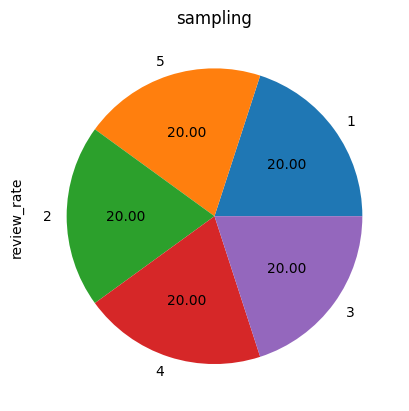

In [ ]:
smote = SMOTE(sampling_strategy = "all")
X, y = smote.fit_resample(X,y)
y = pd.Series(y)
ax = y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("sampling")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [ ]:
model = KNeighborsClassifier()
parameters = {'n_neighbors': range(50, 150, 20)}

In [ ]:
Kneighbors_reg = GridSearchCV(model, parameters, scoring='balanced_accuracy',cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1))

In [ ]:
Kneighbors_reg.fit(X,y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(50, 150, 20)},
             scoring='balanced_accuracy')

In [ ]:
print(Kneighbors_reg.best_estimator_)

KNeighborsClassifier(n_neighbors=50)


In [ ]:
best_model = Kneighbors_reg.best_estimator_
best_model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=50)

In [ ]:
def showStats(model, X_train, X_test, y_train, y_test):
  y_pred_model = model.predict(X_test)
  print('model Classification Train accuracy %s' % model.score(X_train, y_train))
  print('model Classification Test accuracy %s' % accuracy_score(y_pred_model, y_test))
  print(classification_report(y_test, y_pred_model))
  sns.heatmap(confusion_matrix(y_test, y_pred_model), annot=True)

model Classification Train accuracy 0.7372273249138921
model Classification Test accuracy 0.7273249138920781
              precision    recall  f1-score   support

           1       0.97      0.64      0.77       345
           2       0.54      1.00      0.70       347
           3       0.85      1.00      0.92       359
           4       0.75      0.94      0.84       339
           5       0.95      0.06      0.11       352

    accuracy                           0.73      1742
   macro avg       0.81      0.73      0.67      1742
weighted avg       0.81      0.73      0.67      1742



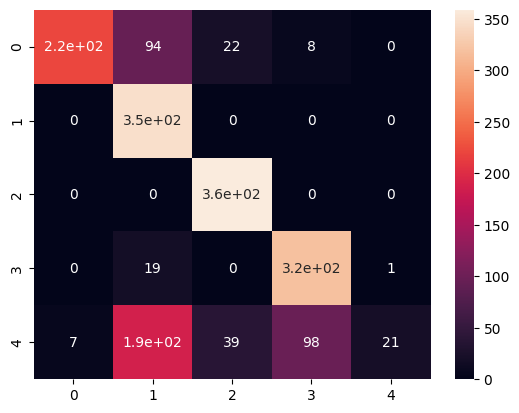

In [ ]:
showStats(best_model, X_train, X_test, y_train, y_test)

# Тест

In [ ]:
def test_pred(test_df):
  test_df['review_name'] = test_df['review_name'].apply(cleanalyzer)
  test_df['review_body'] = test_df['review_body'].apply(cleanalyzer)

  X_name_test = vectorizer_name.transform(test_df['review_name'])
  X_1_test = pd.DataFrame(X_name_test.toarray(), columns=vectorizer_name.get_feature_names_out())

  X_body_test = vectorizer_body.transform(test_df['review_body'])
  X_2_test = pd.DataFrame(X_body_test.toarray(), columns=vectorizer_body.get_feature_names_out())

  X_test = pd.concat([X_1_test, X_2_test], axis=1)

  return best_model.predict(X_test)

In [ ]:
df2 = pd.DataFrame({"review_name": ["Восстановление карты", "Альфабанк просто лучший банк!", "Альфабанк это Дно", "Нет возможности получить у вас карту, не объясняют толком причину отказа", "Неплохой банк"],
                    "review_body": ['Банкомат "зажевал карту, позвонила на горячую линию банка, специалист оперативно помог в решении вопроса: заблокировал карту, оформил новую, новая карта достаточно быстро была доставлена заказным письмом за счет банка по почте РФ. Спасибо большое специалисту банка за компетентность и помощь, банку - за заботу о своем клиенте!',#4
                             'Здравствуйте! Альфабанк лучший банк. Обслуживание топ- все операторы милашки! Нет навязчивых звонков! Понятные условия всех услуг! Люблю! Всегда с удовольствием звоню на горячую линию, нет заученных дурацких фраз, всегда помогут подскажут. отделения тоже чистые, удобные, современные. Спасибо , ребят!', #5
                             'У супруги была кредитная карта это Альфабанк(Днище) банка.27.04.2022 г супруга скоропостижно скончалась.Сообщил об этом по телефону в банк, сказали принести свидетелтство о смерти. Принес.Через 6 месяцев начались звонки о просроченной задолжности. Обьяснил ситуацию. Со мной связался представитель банка. Я ему предложил отправить фото/ксерокс свидетельства о смерти так как был в командировке в другом городе.Знаете, что делает банк? Подает в суд на человека который умер. Достоверно об этом зная и имея возможности убедиться в этом. Он просто подает в суд, вводя в заблужление и сотрудников судебной системы и ФССП.Я был уверен, что это дно, но тут снизу постучал Альфабанк', #1
                             'Доброго времени суток! Обратилась через мобильное приложение для выпуска дебетовой карты 09.09. выбрала доставку курьером . Через несколько часов пришла смс от банка " по решению банка мы не можем активировать вашу карту". Позвонила на горячую линию уточнить причину, так как из смс ничего не понятно. Там посоветовали обратится в отделение банка с паспортом. Быстро поехала в ближайшее отделение узнать. Девушка просканировала мои докуметы, начала заводить заявку и ей выдало, что по техническим причинам мы вам ничего выдать и открыть не можем. Толком ответить , что под этим подразумевется мне не смогли. Так же не было предложено просто открытие счета, без выпуска карты.Сказали, что если вдруг мне позвонят. Сроков никаких не назвали. Знаю, что банк знает эти причины, но своим новым клиентам их оглашать не хочет. Из-за чего еще больше вопросов возникает со стороны возможного клиента. Остался не приятный осадок от такого отношения', #3
                             'Неплохой банк, но напрягают постоянные задержки и ошибки в работе приложения и некачественное обслуживание. Не самый хороший, но и не самый плохой банк',
                             ]})

In [ ]:
print(test_pred(df2))

['2' '2' '2' '2' '2']


# Выводы

Для предсказания оценки отзыва по его содержанию о работе АльфаБанка из совокупности отзывов наиболее оптимальной моделью по скорости и точности на этапе сравнения с другими моделями показала себя KneighborsClassifier. Точность данной модели с учетом попытки ее улучшения (кросс-валидация, фолдировка, сэмплинг, векторизация, жадный поиск) стала равна 0.73, что на 0.15 меньше изначального результата до дообучения. Как итог: модель переобучена в результате чрезмерного увеличения параметра соседей (по дефолту стояло 5, но при семплинге задавался рейндж от 50 до 150, и модель выбрала наименьший вариант, что все равно превышало идеальный). Как можно заметить из heatmap, самым частым случаем для ошибок модели является оценка "2", что и показывают тесты (модель неправильно определила оценку в 3 случаях из 5, ошибочнл приняв ее за 2)

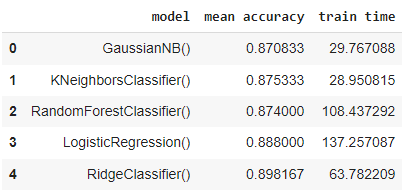